##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [3]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/../data" 

sys.path.append(libDir)

In [4]:
import pandas as pd
import uniprot, go
import numpy as np

In [5]:
%matplotlib nbagg
import matplotlib.pyplot as plt

## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
##### 1 Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

##### 2 Représenter la distribution empirique des "fold-change" (**FC**)
    * Representation d'une grille d'histogrammes
    * Explorer l'effet du paramètre: nombre de catégories
    * Se familliariser avec les objets Axes et Figure
    
##### 3 Evaluer un seuil de **FDR** 5%, avec une approximation par noyau Gaussien de la distribution.
    * Génération d'un jeu de données unimodal (génération par une loi normale)      
    * Rapport d'intégrales et seuil alpha


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *RA*, désigne le **R**atio d'**A**bondance pour une protéines entre deux experiences.

Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```.

Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considérée par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [44]:
# import data
df = pd.read_csv("../TCL_wt1.tsv",sep="\t",dtype={"Accession":str,
"Description":str,
"Gene symbol":str,
"Corrected Abundance ratio (1.53)":np.float64,
"Log2 Corrected Abundance Ratio": np.float64,
"Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)":np.float64,
"LOG10 Adj.P-val":np.float64},na_values='#VALEUR!')

In [45]:
df.dtypes

Accession                                                        object
Description                                                      object
Gene Symbol                                                      object
Corrected Abundance ratio (1.53)                                float64
Log2 Corrected Abundance Ratio                                  float64
Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)    float64
LOG10 Adj.P-val                                                 float64
dtype: object

In [46]:
df.shape

(2024, 7)

In [47]:
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
3,P0CE48,Elongation factor Tu 2 OS=Escherichia coli (st...,tufB,NaN,NaN,NaN,NaN
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768


In [49]:
df = df.dropna()
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,0.036746,1.434787


In [50]:
df.shape

(1746, 7)

In [73]:
log_cRA = df['Log2 Corrected Abundance Ratio'].tolist()
min(log_cRA)

-3.721334942

# Visualisation de la distribution empirique

MATPLOTLIB repose sur deux objets principaux:
* [Figure](https://matplotlib.org/stable/api/figure_api.html)
* [AXE](https://matplotlib.org/stable/api/axes_api.html#basic)


Représenter la distribution des **RA** des protéines de l'experience [**Log2 Corrected Abundance Ratio**].
* Réaliser une grille 2x2 avec 4 histogrammes présentant chacun un nombre de catégories différent.
    * Histogramme est une [méthode des objets AXE]
(https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist)
    * La taile de la grille est donnée par les paramètres *ncols, nrows*, voir ci dessous
  
`fig1, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(figsize=(10,6), ncols=2, nrows=2)`

<IPython.core.display.Javascript object>


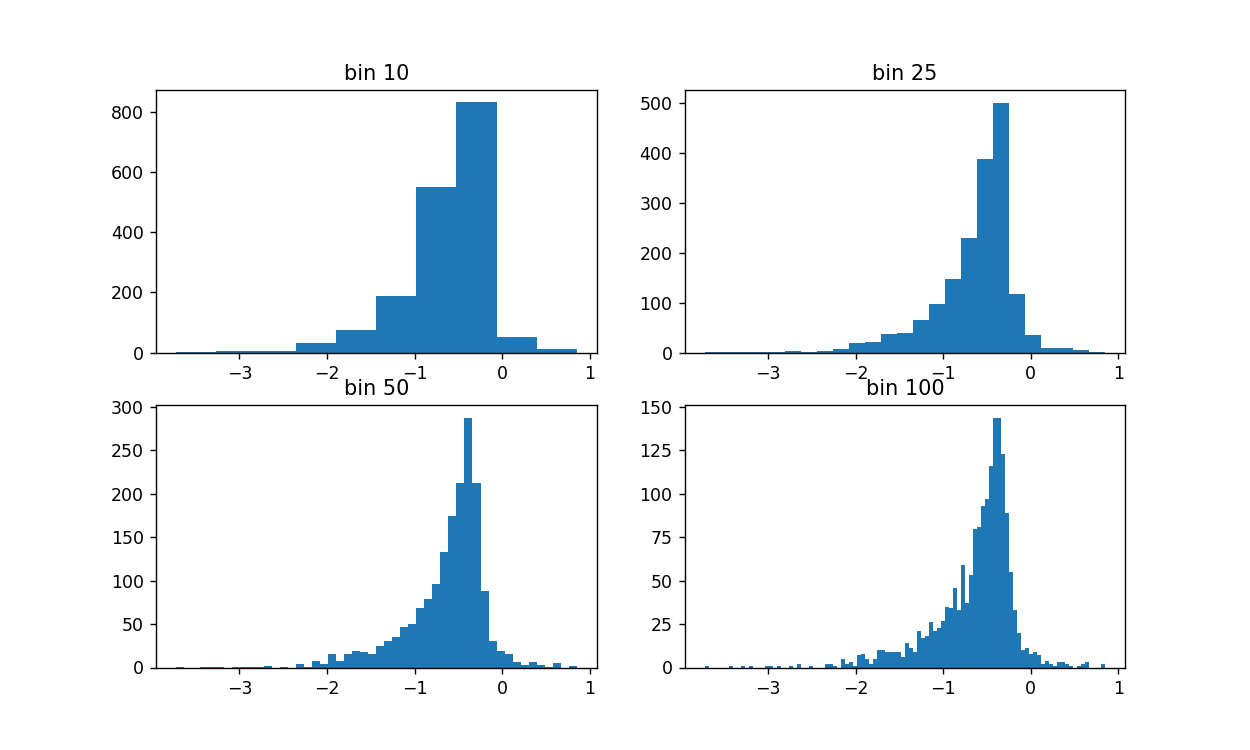

Text(0.5, 1.0, 'bin 100')

In [115]:
fig1, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(figsize=(10,6), ncols=2, nrows=2)
ax1.hist(log_cRA, bins=10)
ax1.set_title("bin 10")
ax2.hist(log_cRA, bins=25)
ax2.set_title("bin 25")
ax3.hist(log_cRA, bins=50)
ax3.set_title("bin 50")
ax4.hist(log_cRA, bins=100)
ax4.set_title("bin 100")

### Réaliser une Kernel Density Estimation sur un histogramme matplotlib à l'aide du package scipy.
#### 1. En manipulant une représentation déjà produite sur un jeu de données aléatoires
#### 2. En appliquant cette technique au jeu de données expérimentales

###### 1/ Générer 1000 valeurs normalement distribuées.
$\Rightarrow$ Evaluez la cellule suivante

In [82]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
print(f"s est un tableau de {len(s)} valeurs normalement distribuées autour de {mu}")
print(f"Les 10 premières valeurs de s sont \n{s[:10]}")

s est un tableau de 1000 valeurs normalement distribuées autour de 0
Les 10 premières valeurs de s sont 
[ 0.09279777 -0.01625901  0.05610202 -0.1030381  -0.02936188 -0.00911616
  0.13716202 -0.01664023  0.01645487 -0.03577061]


In [117]:
print(s)

[ 9.27977702e-02 -1.62590097e-02  5.61020209e-02 -1.03038095e-01
 -2.93618814e-02 -9.11616042e-03  1.37162017e-01 -1.66402277e-02
  1.64548708e-02 -3.57706099e-02  1.74670578e-01 -1.11435236e-01
  1.22057011e-01 -1.07026365e-01 -1.46615388e-01  1.42500892e-01
 -1.08597001e-01 -5.95909352e-02 -1.06583066e-01 -4.14697711e-02
 -1.54567512e-01  8.20996273e-02 -1.41240103e-01  5.82810142e-02
 -4.10914983e-02 -5.82054699e-04 -8.59981485e-02  6.00825418e-02
  5.60208307e-02 -1.05915367e-01 -3.43214878e-03  5.25832929e-02
  1.52208042e-01 -9.43765032e-02  1.57167678e-01 -1.44464069e-01
 -8.34329864e-02 -2.95222190e-02  1.65644590e-01 -9.34196790e-02
 -6.73493202e-02  7.70520879e-02 -2.03234807e-01  8.21248959e-03
  3.17665513e-02 -2.92193563e-02 -7.16160830e-02  1.78479607e-01
  4.86235269e-02  1.13737793e-01 -3.81828240e-02 -3.97836565e-02
  2.30046187e-02  8.82703474e-03 -3.28549749e-02 -1.43838070e-02
  2.27846609e-03 -1.33541445e-02 -1.14995731e-01 -1.72608174e-01
 -4.29410221e-02  1.64857

###### 2/ Créer une figure dotée d'un seul "axe"
Dessinons-y l'histogramme des valeurs précedemment générées
* La méthode ax.hist retourne des valeurs !
* Observez les contenus de *count* et *bin*

$\Rightarrow$ Evaluez la cellule suivante

<IPython.core.display.Javascript object>


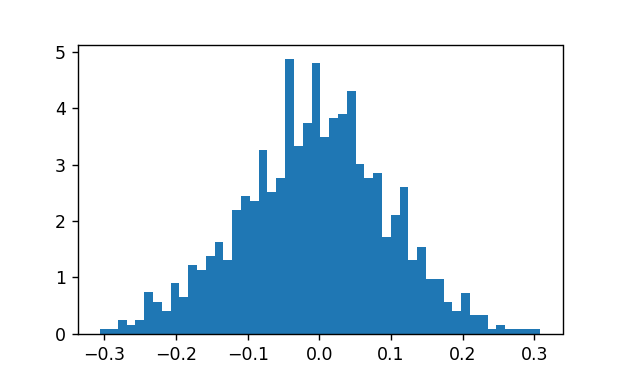

In [118]:
fig2, f2_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
count, bins, barObj = f2_ax.hist(s, 50, density=True) # avec True, matplotlib s'assure que l'aire sous la courbe de densite vaut 1

###### 2/ Estimer la densité de probabilité des 1000 valeurs par noyau Gaussien
Oui c'est bête :D, nous savons que la densité sous-jacente est celle d'une loi normale, mais l'exemple est ainsi assez simple.

$\Rightarrow$ Evaluez la cellule suivante

In [104]:
from scipy.stats.kde import gaussian_kde
pdf_by_gaussian = gaussian_kde(s)

###### 2(suite)/ Générer la courbe cette densité
* Prenons 1000 points points également répartis entre le minimum et le maximum du jeu de données
* Générons les valeurs correspondantes dans la densité

$\Rightarrow$ Evaluez la cellule suivante

Vous pouvez plotez ces deux listes de valeurs dans un graphique simple

In [105]:
x_kde = np.linspace(min(s),max(s), 1000)
y_kde = pdf_by_gaussian(x_kde)

#### 3/ Estimation de densité et histogramme

* Ajoutez sur le même graphique histogramme et courbe de densité

* Mettez le paramètre `density` à False sur `count, bins, barObj = f2_ax.hist(s, 50, density=True)`
    * Qu'observez-vous en ordonnées?
    * Pouvez-vous expliquer le changement de "forme" de la courbe de densité?
    * L'aire sous la courbe et/ou sous l'histogramme change-t-elle avec le booléen density?


* Peut-on imaginer une technique pour dessiner histogramme et courbe de densité avec les bonnes unités en ordonnées ?
    * Les variables count et bins peuvent notamment vous aider à calculer l'aire totale sous l'histogramme.
    
* Dessiner histogramme et courbe de densité avec les bonnes unités et les légendes et titres correspondants.

<IPython.core.display.Javascript object>


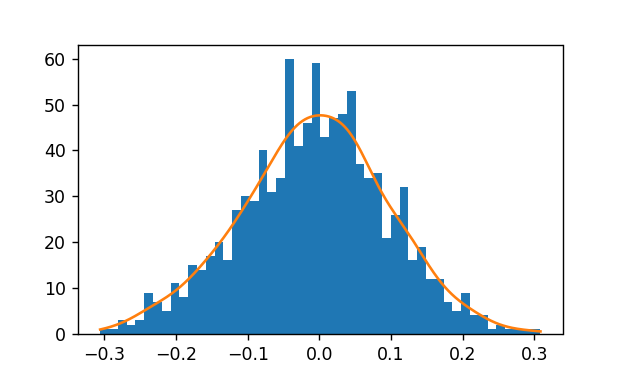

In [153]:
fig3, ax3 = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
count, bins, barObj = ax3.hist(s, 50, density=False) # l'histogramme est beaucoup plus grand par rapport a tout a l'heure
# count c'est l'hauteur de chaque barre de l'hist
# bins sont les borne de chaque intervalle (vaut count+1)

scale = 0

for i in range(count.shape[0]):
    h = count[i]
    l = bins[i+1] - bins[i]
    scale += h*l
    
ax3.plot(x_kde, y_kde*scale)

#### 4/ Recherche du seuil alpha

Le package scipy.integrate permet de calculer l'intégrale exacte d'une fonction 

`integral_value, residu = scipy.integrate.quad(f, borne_inf, borne_sup)`

* A l'aide de l'exemple ci-dessus:

    * Calculer la valeur de l'aire sous la courbe de densité estimée entre les valeurs minimale et maximale du jeux de données
    * Chercher la borne d'intégration inférieure **alpha** correspondant "à peu près" à 5% de l'aire totale sous la courbe de la  de densité de probabilité estimée.


In [168]:
import scipy.integrate
integral_value, residu = scipy.integrate.quad(pdf_by_gaussian, x_kde.min(), x_kde.max())
integral_value, residu

(0.9976009966092005, 9.9535768711582e-09)

In [162]:
alpha = 0.05

###### 5/ Représentation graphique du seuil alpha
Redessinez le graphique *histogramme et courbe de densité* mais avec:
* une ligne verticale rouge matérialisant le seuil **alpha**
* Un [texte](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html) `alpha(5%) = {valeur de alpha}`
* (Bonus) coloriez en rouge [l'aire sous la courbe](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.fill_between.html) de densité correspondant à l'intégrale calculée.

In [ ]:
#### A VOUS DE JOUER

## Appliquez cette méthode pour determiner un seuil alpha pour le ratio d'abondance
* Liste de valeurs `Log2 Corrected Abundance Ratio`
1. Estimation de la densité par noyau gaussien 
2. Calcul du seuil alpha
3. Représentation graphique
    * Histogramme
    * Densité 
    * seuil alpha

In [ ]:
### Cellule Exercice